In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import logging
from pathlib import Path
import textwrap
import copy
from PIL import Image, ImageDraw, ImageFont
from waveshare_epd import epd2in7b

In [4]:
import constants


In [5]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [54]:
class TextBlock:
    '''Class for creating a 1 bit image of word-wrapped text
    
    Args
    ----
        resolution (int, int): tuple of ints representing maximum resolution of image
        text (str): text to format into image
        font (str): path to ttf font
        size (int): size of font in points (pixles)
        maxrows (int): maximum number of wrapped rows of text; surplus is discarded
        maxchar (int): maximum number of characters per row
            this is automatically calculated if not specified based on font face, font size
            and letter frequency (see chardist below)
        chardist (dict): character frequency distribution for a particular language
            provided distributions in constants.py: 
            USA_CHARDIST+, FRA_CHARDIST, DEU_CHARDIST, PRT_CHARDIST, ITA_CHARDIST, TUR_CHARDIST,
            SWE_CHARDIST, NED_CHARDIST, DAN_CHARDIST
                + only USA english includes upper and lower case characters
        coordinates (int, int): location on screen image should be positioned (not used locally)
    
    Attributes
    ----------
        resolution (int, int): max resolution of image in px
        font (ImageFont.trueType): font and size to use
        maxchar (int): maximum number of characters per row
        maxrows (int): maximum number of wrapped rows of text; surplus is discarded
        coordinates (int, int): position of text in final image (not used in this class)
        size (int, int): size of text image in px
        text (str): raw text
        formatted (str): wrapped text
        textimage (ImageDraw.Draw): 1 bit image containing formatted text text


    '''
    def __init__(self, resolution=(246, 176), text=' ', font=constants.FONT, size=24, maxrows=3,
                 maxchar=None, coordinates=(0, 0), chardist=constants.USA_CHARDIST):
        self.resolution=resolution
        self.font = ImageFont.truetype(str(Path(font).absolute()), size)
        self._chardist = chardist
        self.maxchar = maxchar
        self.maxrows = maxrows
        self.coordinates = coordinates
        self.text = text
    
        
    @property
    def resolution(self):
        '''maximum resolution in for image
        
        ::2-tuple of int'''
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
#         for r in resolution:
#             if not isinstance(r, int):
#                 raise TypeError(f'resolution must be type int: {r}')
#             if r < 0:
#                 raise ValueError(f'resolution must be positive: {r}')
        if self.coordcheck(resolution):
            self._resolution = resolution
        else:
            raise ValueError(f'bad resolution value: {resolution}')
    
    @property
    def coordinates(self):
        '''coordinates to place the formatted text within the final image (not used in this method)
        
        ::2 tuple of int'''
        return self._coordinates
    
    @coordinates.setter
    def coordinates(self, coordinates):
        if self.coordcheck(coordinates):
            self._coordinates = coordinates
        else:
            raise ValueError(f'bad coordinate values: {coordinates}')
    
    @property
    def maxchar(self):
        '''maximum number of characters per row
            if no value is set this is calculated based on font face, font size and letter frequency
            
        ::int'''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self.__maxchar = maxchar
            return(maxchar)
        else:
            s = ''
            n = 1000 # sample string size for measuring
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            sLenPX = self.font.getsize(s)[0] # string length in Pixles
            avgCharLen = sLenPX/len(s)
            maxchar = round(self.resolution[0]/avgCharLen)
            self._maxchar = maxchar
    
    @property
    def text(self):
        '''raw text
        
        ::str'''
        return self._text
    
    @text.setter
    def text(self, text):
        if not text:
            self.text = None
        else:
            self._text = text
            self.formatted = self.formattext()
            self.image = self.textimage()
    
    @property
    def maxrows(self):
        '''maximum number of rows to use when wrapping text
        
        ::int'''
        return self._maxrows
    
    @maxrows.setter
    def maxrows(self, maxrows):
        if maxrows < 1:
            raise ValueError(f'maxrows must be greater than 0: {maxrows}')
        if not isinstance(maxrows, int):
            raise ValueError(f'maxrows must be type integer: {maxrows}')
        self._maxrows = maxrows
    
    def formattext(self, text=None, maxchar=None, maxrows=None):
        '''format text using word-wrap strategies
        
        Args
        ----
            text (str): raw text
            maxchar (int): maximum number of characters in each row
            maxrow (int): maximum number of rows
            
        Returns
        -------
            ::str'''
        if not maxchar:
            maxchar = self.maxchar
        if not maxrows:
            maxrows = self.maxrows
        if not text:
            text = self.text
        
        wrapper = textwrap.wrap(text, width=maxchar)
        myText = "\n".join(wrapper[0:maxrows])
        if len(myText) < 1:
            myText = ' '
        return(myText)
    
    def textimage(self, text=None, coordinates=None):
        '''produces 1 bit image of containing wrapped text
        
        Args
        ----
            text (str): raw text to use; if non is provided use self.text
            coordinates (int): coordinates of text in final image (not used in this class)
            
        Returns
        -------
            ::Image.new()'''
        if text:
            text = self.formattext(text)
        else:
            text = self.formatted
            
        if not coordinates:
            coordinates = self.coordinates

        # get the size of the text
        draw = ImageDraw.Draw(Image.new('1', (1, 1))) # create a dummy image and drawing instance
        self.size = draw.textsize(text, self.font)
        
        logging.debug(f'text size: {self.size}')
        # create an empty image
        image = Image.new('1', self.size, 255) # create a blank image 
        # get a drawing context
        draw = ImageDraw.Draw(image)
#         draw.text        
        draw.text((0,0), text, font=self.font) # draw the text at the origin
        self.image = image
        return image

    def coordcheck(self, coordinates):
        for c in coordinates:
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: {c}')
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: {c}')
                return False # redundant
        return True

In [90]:
class Screen:
    def __init__(self, resolution=(246, 176), elements=[]):
        self.resolution = resolution
        self.elements = elements
        self.image = Image.new('1', self.resolution, 255)
        
    @property
    def resolution(self):
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
        if self.coordcheck(resolution):
            self._resolution = resolution

    def concat(self):
        for e in self.elements:
            self.image.paste(e.image, (e.coordinates))
        return(self.image)
        
    def coordcheck(self, coordinates):
        for c in coordinates:
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: {c}')
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: {c}')
                return False # redundant
        return True        

In [56]:
t = TextBlock(text='Father of the Bride', size=36)

DEBUG:root:text size: (154, 82)


In [57]:
t.coordinates

(0, 0)

In [58]:
t.size

(154, 82)

In [95]:
a = TextBlock(text='Vampire Weekend', size = 24, coordinates=(0, t.size[1]))

DEBUG:root:text size: (203, 32)


In [96]:
a.coordinates

(0, 82)

In [97]:
s = Screen(elements=[a, t])

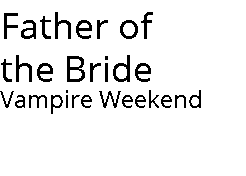

In [98]:
s.concat()

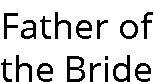

In [61]:
t.image

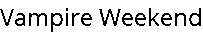

In [62]:
a.image

In [35]:
t.size
t.coordinates

(0, 0)

In [16]:
t.coordinates

(0, 0)

In [80]:
# ((size), (position))
# find the size if all images were concatinated together
cords = [((10, 10), (50, 10)), ((120, 120), (0, 0)), ((120, 120), (120, 0)), ((240, 60), (0, 120)), ((50, 100), (170, 70))]

In [81]:
x = 0
y = 0
lastX = 0
lastY = 0
for c in cords:
    thisX = c[1][0] + c[0][0]
    thisY = c[1][1] + c[0][1]
    
    if thisX > lastX:
        lastX = thisX
        print(f'found a new X max {lastX}')
    
    if thisY > lastY:
        lastY = thisY
        print(f'found a new Y max {lastY}')
        
print(lastX, lastY)

found a new X max 60
found a new Y max 20
found a new X max 120
found a new Y max 120
found a new X max 240
found a new Y max 180
240 180
